# Project02 - Charity Navigator

The goal of this project is to 

In [469]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

%matplotlib inline

/Users/laurachen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [527]:
#Reading in the data from the scrapy spider (Charity_Spider.py) that scraped the Charity Navigator website
data = json.load(open('charities.json'))

In [528]:
df=pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 14 columns):
CEOsalary               308 non-null object
admin_exp               308 non-null object
liab_to_assets          308 non-null object
mkting_exp              308 non-null object
name                    308 non-null object
perc_admin_exp          308 non-null object
perc_fundraising_exp    308 non-null object
perc_program_exp        308 non-null object
program_exp_growth      308 non-null object
revenue                 308 non-null object
state                   308 non-null object
tpscore                 308 non-null object
url                     308 non-null object
wking_cap_ratio         308 non-null object
dtypes: object(14)
memory usage: 33.8+ KB


In [529]:
#removing data with insignificant values
print(df.shape)
df=df[df['liab_to_assets']!='< 0.1%']
df=df[df['wking_cap_ratio']!='< 0.01']
print(df.shape)

(308, 14)
(292, 14)


In [530]:
#cleaning up the data
df.CEOsalary=df.CEOsalary.str.strip()
df.CEOsalary.replace(to_replace=["None reported","Not compensated"],value=np.NaN,inplace=True)

#converting the cash strings into floats
num_cols=['CEOsalary','admin_exp','mkting_exp','revenue','tpscore','wking_cap_ratio']
for col in num_cols:
    df[col]=df[col].str.replace("$","").str.replace(",","").str.replace("%","").apply(float)

perc_cols=['perc_fundraising_exp','perc_program_exp','program_exp_growth','liab_to_assets','perc_admin_exp']
for col in perc_cols:
    df[col]=df[col].str.replace("%","").apply(float)/100

In [548]:
#testing adjusted Transparency Score
df[df['tpscore']<95]
#df['adj_tpscore']

,CEOsalary,admin_exp,liab_to_assets,mkting_exp,name,perc_admin_exp,perc_fundraising_exp,perc_program_exp,program_exp_growth,revenue,state,tpscore,url,wking_cap_ratio,perc_CEOsalary
2,101917.0,375979.0,0.036,256741.0,Arizona Animal Welfare League & SPCA,0.064,0.073,0.861,0.030,2363905.0,AZ,89.0,http://www.charitynavigator.org/index.cfm?bay=...,1.54,0.043114
4,105312.0,51578.0,0.240,90070.0,Animals' Angels,0.060,0.100,0.838,0.055,980043.0,MD,85.0,http://www.charitynavigator.org/index.cfm?bay=...,0.48,0.107457
12,NaN,54083.0,0.004,70215.0,"Animal Rescue, Inc.",0.046,0.061,0.892,0.028,1199325.0,PA,93.0,http://www.charitynavigator.org/index.cfm?bay=...,2.25,NaN
15,56755.0,208773.0,0.027,37623.0,"Animal Rescue League of Berks County, Inc.",0.127,0.045,0.826,0.076,1143251.0,PA,85.0,http://www.charitynavigator.org/index.cfm?bay=...,1.30,0.049644
16,78500.0,433908.0,0.014,439059.0,Animal Rescue Fund of the Hamptons,0.123,0.127,0.748,0.078,3860108.0,NY,93.0,http://www.charitynavigator.org/index.cfm?bay=...,4.33,0.020336
17,106003.0,234157.0,0.046,332262.0,Animal Refuge League,0.098,0.165,0.735,0.042,2005637.0,ME,92.0,http://www.charitynavigator.org/index.cfm?bay=...,6.03,0.052853
18,11293.0,210623.0,0.008,226632.0,Animal Protective Association of Missouri,0.099,0.125,0.774,0.066,891375.0,MO,85.0,http://www.charitynavigator.org/index.cfm?bay=...,3.69,0.012669
21,64500.0,70444.0,0.086,235812.0,Faithful Friends Animal Society,0.034,0.132,0.833,0.161,1337523.0,DE,77.0,http://www.charitynavigator.org/index.cfm?bay=...,0.57,0.048223
26,79280.0,91236.0,0.036,160097.0,Greater Androscoggin Humane Society,0.090,0.135,0.773,-0.002,771607.0,ME,62.0,http://www.charitynavigator.org/index.cfm?bay=...,2.50,0.102747
27,134282.0,518321.0,0.487,644347.0,Great Plains SPCA,0.080,0.091,0.827,0.231,4633745.0,KS,93.0,http://www.charitynavigator.org/index.cfm?bay=...,0.14,0.028979


In [531]:
df.head()

,CEOsalary,admin_exp,liab_to_assets,mkting_exp,name,perc_admin_exp,perc_fundraising_exp,perc_program_exp,program_exp_growth,revenue,state,tpscore,url,wking_cap_ratio
0,173743.0,1825251.0,0.060,1046488.0,Animal Legal Defense Fund,0.151,0.113,0.734,0.212,10935550.0,CA,96.0,http://www.charitynavigator.org/index.cfm?bay=...,1.21
1,317857.0,595444.0,0.047,2255697.0,Arizona Humane Society,0.037,0.129,0.832,0.085,12879259.0,AZ,100.0,http://www.charitynavigator.org/index.cfm?bay=...,2.18
2,101917.0,375979.0,0.036,256741.0,Arizona Animal Welfare League & SPCA,0.064,0.073,0.861,0.030,2363905.0,AZ,89.0,http://www.charitynavigator.org/index.cfm?bay=...,1.54
3,193752.0,539033.0,0.024,1176516.0,The Anti-Cruelty Society,0.059,0.137,0.802,0.052,6281094.0,IL,100.0,http://www.charitynavigator.org/index.cfm?bay=...,6.00
4,105312.0,51578.0,0.240,90070.0,Animals' Angels,0.060,0.100,0.838,0.055,980043.0,MD,85.0,http://www.charitynavigator.org/index.cfm?bay=...,0.48


In [532]:
df['perc_CEOsalary']=df['CEOsalary']/df['revenue']

In [534]:
#Selecting the desired columns for analysis
#Removed due to high p values: 'perc_CEOsalary', 'revenue', and 'wking_cap_ratio'
df_clean = df.loc[:,[ 'program_exp_growth','perc_program_exp', 'liab_to_assets', 'perc_admin_exp', 'name'\
                     , 'perc_fundraising_exp','tpscore',]].set_index('name')

In [535]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, Animal Legal Defense Fund to Northwest Organization for Animal Help
Data columns (total 6 columns):
program_exp_growth      292 non-null float64
perc_program_exp        292 non-null float64
liab_to_assets          292 non-null float64
perc_admin_exp          292 non-null float64
perc_fundraising_exp    292 non-null float64
tpscore                 292 non-null float64
dtypes: float64(6)
memory usage: 16.0+ KB


In [536]:
#Checking out the high level information on the DF
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, Animal Legal Defense Fund to Northwest Organization for Animal Help
Data columns (total 6 columns):
program_exp_growth      292 non-null float64
perc_program_exp        292 non-null float64
liab_to_assets          292 non-null float64
perc_admin_exp          292 non-null float64
perc_fundraising_exp    292 non-null float64
tpscore                 292 non-null float64
dtypes: float64(6)
memory usage: 16.0+ KB


In [537]:
#Reviewing the summary statistics
df_clean.describe()

,program_exp_growth,perc_program_exp,liab_to_assets,perc_admin_exp,perc_fundraising_exp,tpscore
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,0.067839,0.802034,0.088271,0.093185,0.103288,92.575342
std,0.109748,0.066285,0.099797,0.047853,0.050795,8.837468
min,-0.365000,0.503000,0.001000,0.015000,0.004000,47.000000
25%,0.023000,0.763000,0.019000,0.062000,0.067750,89.000000
50%,0.056500,0.807500,0.045500,0.085000,0.098000,96.000000
75%,0.096500,0.845500,0.133500,0.113500,0.136000,100.000000
max,1.346000,0.946000,0.511000,0.322000,0.344000,100.000000


In [538]:
df_clean.corr()

,program_exp_growth,perc_program_exp,liab_to_assets,perc_admin_exp,perc_fundraising_exp,tpscore
program_exp_growth,1.000000,0.021792,0.054389,-0.126464,0.091135,-0.183493
perc_program_exp,0.021792,1.000000,0.044950,-0.647316,-0.695537,0.167209
liab_to_assets,0.054389,0.044950,1.000000,-0.086686,0.023088,-0.037158
perc_admin_exp,-0.126464,-0.647316,-0.086686,1.000000,-0.097366,-0.109618
perc_fundraising_exp,0.091135,-0.695537,0.023088,-0.097366,1.000000,-0.115772
tpscore,-0.183493,0.167209,-0.037158,-0.109618,-0.115772,1.000000


In [539]:
df_clean.sort_values(by="perc_program_exp", ascending=False).head()

,program_exp_growth,perc_program_exp,liab_to_assets,perc_admin_exp,perc_fundraising_exp,tpscore
name,,,,,,
Animal Welfare Institute,-0.150,0.946,0.001,0.042,0.010,100.0
Michigan Anti-Cruelty Society,0.038,0.935,0.017,0.045,0.019,100.0
Canine Assistants,-0.075,0.932,0.511,0.050,0.016,85.0
Greenville Humane Society,0.114,0.930,0.013,0.035,0.034,100.0
Pet Alliance of Greater Orlando,0.028,0.928,0.074,0.038,0.033,100.0


100.0    99
96.0     43
89.0     29
93.0     26
97.0     22
85.0     16
92.0     11
78.0      6
82.0      6
81.0      5
73.0      5
70.0      4
74.0      4
77.0      4
88.0      3
75.0      2
62.0      2
79.0      1
47.0      1
86.0      1
69.0      1
66.0      1
Name: tpscore, dtype: int64

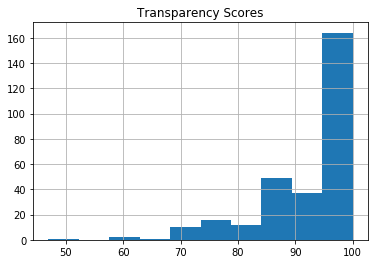

In [547]:
df.tpscore.hist().set_title('Transparency Scores');
#box-cox transformation?

df.tpscore.value_counts()

In [541]:
lr = LinearRegression()
X = df_clean.iloc[:, 2:]
# Choose the response variable(s)
y = df_clean.iloc[:, 0]
# Fit the model to the full dataset
lr.fit(X, y)

Linear Regression: 
 score:  0.0595028048662 
 intercept:  0.301840441089 
 coefficients: [ 0.03734755 -0.31913249  0.11812538 -0.00237386]


In [500]:
mod_features="program_exp_growth ~" + "+".join(df_clean.columns[1:])

In [542]:
#Fitting the model against the full dataset
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(mod_features, data=df_clean, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
# what is happening when we call fit?
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     program_exp_growth   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.656
Date:                Sat, 20 Jan 2018   Prob (F-statistic):            0.00319
Time:                        10:16:09   Log-Likelihood:                 240.41
No. Observations:                 292   AIC:                            -468.8
Df Residuals:                     286   BIC:                            -446.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.9689     12.614     -0.394      0.694     -29.798      19.860
perc_program_exp         5.2767     12.629      0.418      0.676     -19.580      30.133
liab_to_assets           0.0373      0.063      0.588      0.557      -0.087       0.162
perc_admin_exp           4.9577     12.629      0.393      0.695     -19.901      29.816
perc_fundraising_exp     5.3920     12.622      0.427      0.670     -19.452      30.236
tpscore                 -0.0024      0.001     -3.241      0.001      -0.004      -0.001
==============================================================================
Omnibus:                      308.442   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23276.453
Skew:                           4.128   Prob(JB):                         0.00
Kurtosis:                      45.953   Cond. No.                     3.74e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [543]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(mod_features, data=df_clean, return_type="dataframe")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [544]:
# Create your model
model = sm.OLS(y_train, X_train)
# Fit your model to your training set
# what is happening when we call fit?
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     program_exp_growth   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.707
Date:                Sat, 20 Jan 2018   Prob (F-statistic):            0.00318
Time:                        10:17:18   Log-Likelihood:                 145.46
No. Observations:                 195   AIC:                            -278.9
Df Residuals:                     189   BIC:                            -259.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.5734     16.944     -0.093      0.926     -34.997      31.850
perc_program_exp         1.9159     16.962      0.113      0.910     -31.543      35.375
liab_to_assets           0.0110      0.082      0.134      0.893      -0.150       0.172
perc_admin_exp           1.4842     16.971      0.087      0.930     -31.994      34.962
perc_fundraising_exp     2.1083     16.946      0.124      0.901     -31.319      35.535
tpscore                 -0.0027      0.001     -2.925      0.004      -0.005      -0.001
==============================================================================
Omnibus:                      232.462   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14112.340
Skew:                           4.660   Prob(JB):                         0.00
Kurtosis:                      43.621   Cond. No.                     3.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [545]:
y_pred = fit.predict(X_test)

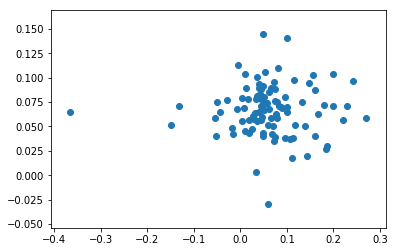

In [546]:
plt.scatter(y_test,y_pred)